We will implement a Gibbs sampling algortihm to sample the factors from the conditional posterior distrubtions in the MVGMF algorithm to factorise our matrix. We will call this algortihm Bayesian Gaussian Matrix Factorisation (BGMF) for now.

In [298]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
plt.style.use('seaborn-white')

In [299]:
def calculate_nmse(Y, Y_pred):
    numerator = np.linalg.norm(Y - Y_pred, 'fro') ** 2
    denominator = np.linalg.norm(Y, 'fro') ** 2
    nmse = numerator / denominator
    return nmse

In [300]:
def matrix_normal_sample(M, U, V):
    #return np.random.multivariate_normal(M.ravel(), np.kron(V, U)).reshape(M.shape)
    n, p = M.shape

    # Generate samples from standard normal distribution
    X = np.random.normal(0, 1, size=(n, p))

    # Compute Cholesky decomposition of covariance matrices
    chol_U = np.linalg.cholesky(U)
    chol_V = np.linalg.cholesky(V)

    # Sample from matrix normal distribution
    Y = M + chol_U @ X @ chol_V.T

    return Y

In [374]:
def BGMF(Y, k, r, T, sigma_2, burnin = 100, return_running_average = False, return_samples=False):
    """
    Perform Bayesian Gaussian Matrix Factorization (BGMF) using Gibbs sampling.

    Parameters:
    - Y (numpy.ndarray): The input matrix of shape (m, n) to be factorized.
    - k (float): A constant for the variate matrix initialization.
    - r (int): The dimensionality of the factorization.
    - T (int): The number of Gibbs sampling iterations.
    - burnin(int): Specifies burnin iterations.
    - return_running_average (boolean): Returns running array average of C and X.
    - return_samples (boolean): Returns array of samples of C and X at each iteration.

    Returns:
    - C (numpy.ndarray): The factor matrix C of shape (m, r).
    - X (numpy.ndarray): The factor matrix X of shape (r, n).
    """
    m, n = Y.shape
    #Initialise the matrices
    V_0 = k * np.eye(r)
    W_0 = k * np.eye(r)
    C_0 = np.random.normal(0, 1, size=(m, r))
    X_0 = np.random.normal(0, 1, size=(r, n))
    C_prev = C_0.copy()
    X_prev = X_0.copy()

    initial_V_0 = V_0.copy()
    initial_W_0 = W_0.copy()


    #Stores running average of C and X after burnin
    C_samples = []
    X_samples = []
    V_samples = []
    W_samples = []
    C_running_average = []
    X_running_average = []
    C_average = np.zeros((m, r))
    X_average = np.zeros((r, n))
    C_mean_array = []
    X_mean_array = []

    for t in range(T):
        
        
        #V = V_0 - V_0 @ X_prev @ np.linalg.inv(sigma_2*np.eye(n) + X_prev.T @ V_0 @ X_prev).T @ X_prev.T @ V_0.T
        V = V_0 - V_0 @ X_prev @ np.linalg.inv(sigma_2*np.eye(n) + X_prev.T @ V_0 @ X_prev) @ X_prev.T @ V_0
        
        C_mean = C_prev + (Y - C_prev @ X_prev) @ \
                    np.linalg.inv(sigma_2*np.eye(n) + X_prev.T @ V_0 @ X_prev).T @ X_prev.T @ V_0.T
        
        C = matrix_normal_sample(C_mean, np.eye(m), V)
        
        W = W_0 - W_0 @ C.T @ np.linalg.inv(sigma_2*np.eye(m) + C @ W_0 @ C.T) @ C @ W_0
        
        X_mean = X_prev + W_0 @ C.T @ np.linalg.inv(sigma_2*np.eye(m) + C @ W_0 @ C.T) @ (Y - C @ X_prev)
        
        X = matrix_normal_sample(X_mean, W, np.eye(n))
        
        C_prev = C
        X_prev = X
        
        if t >= burnin:
            #Calculates the running average of C and X (to plot)
            if t == burnin:
                C_average = C
                X_average = X
                C_running_average.append(C_average)
                X_running_average.append(X_average)
                
            else:
                N = t - burnin + 1
                C_average = (C / N) + (C_average * (N - 1) / N)
                X_average = (X / N) + (X_average * (N - 1) / N)
                C_running_average.append(C_average)
                X_running_average.append(X_average)
                
            C_mean_array.append(C_mean)
            X_mean_array.append(X_mean)
                
            #Stores the samples at each stage after burnin
            C_samples.append(C)
            X_samples.append(X)
            V_samples.append(V)
            W_samples.append(W)
        
        # W_0 *= 0.99
        # V_0 *= 0.99
            

    if return_running_average:
        return C_average, X_average, C_running_average, X_running_average
    
    elif return_samples:
        return C_average, X_average, C_samples, X_samples, V_samples, W_samples, C_0, X_0, initial_V_0, initial_W_0, C_mean_array, X_mean_array
            
    return C_average, X_average

In [375]:
def calculate_running_average(Y):
    result = []
    result.append(Y[0])
    Y_average = Y[0]
    for i in range(1, len(Y)):
        Y_average = (Y[i] / (i+1)) + (Y_average * (i) / (i+1))
        result.append(Y_average)
    return np.array(result)

In [398]:
np.random.seed(0)
m = 100
r = 5
n = 50
burnin = 500
T = 1000
sigma_2 = 1
k = 0.001

C = np.random.normal(10, 1, size=(m, r))
X = np.random.normal(5, 1, size=(r, n))

Y = C @ X + np.random.normal(0, np.sqrt(sigma_2), size=(m, n))
#C_pred, X_pred, C_average, X_average = BGMF(Y, 1, r, T, burnin = burnin, return_running_average = True)
C_pred, X_pred, C_samples, X_samples, V_samples, W_samples, C_0, X_0, V_0, W_0, C_mean_array, X_mean_array \
                    = BGMF(Y, k, r, T, sigma_2, burnin = burnin, return_samples = True)
    
C_average = calculate_running_average(C_samples)
X_average = calculate_running_average(X_samples)

Y_pred = C_pred @ X_pred
#RUNNING PREDICITION CALCULATION
Y_pred_running = np.array([C @ X for C, X in zip(C_average, X_average)])
nmse_running = [calculate_nmse(Y, Y_pred) for Y_pred in Y_pred_running]


NMSE at 0th iteration: 1.0005035614231461
NMSE at final iteration: 1.4230166293799891e-05


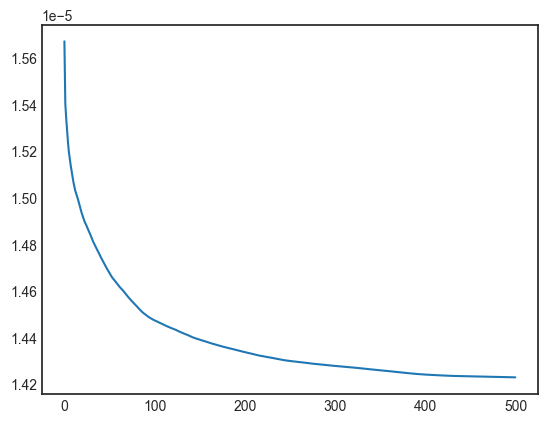

In [399]:
plt.plot(range(T-burnin), nmse_running)
print(f"NMSE at 0th iteration: {calculate_nmse(Y, C_0 @ X_0)}")
print(f"NMSE at final iteration: {calculate_nmse(Y, Y_pred)}")

Text(0.5, 1.0, 'How C_2,2 varies')

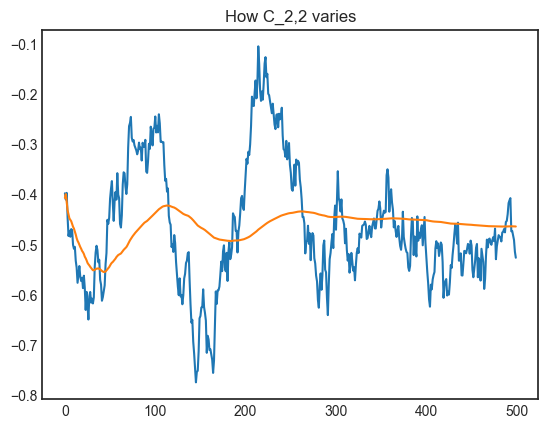

In [400]:
n = len(C_mean_array)
C_mean_array = np.array(C_mean_array)
C_samples = np.array(C_samples)
plt.plot(range(n), C_mean_array[:, 2, 2])
plt.plot(range(n), C_average[:, 2, 2])
#plt.axhline(y=C[1,1], color='r', linestyle='-')
plt.title('How C_2,2 varies')


Text(0.5, 1.0, 'How X_2,2 varies')

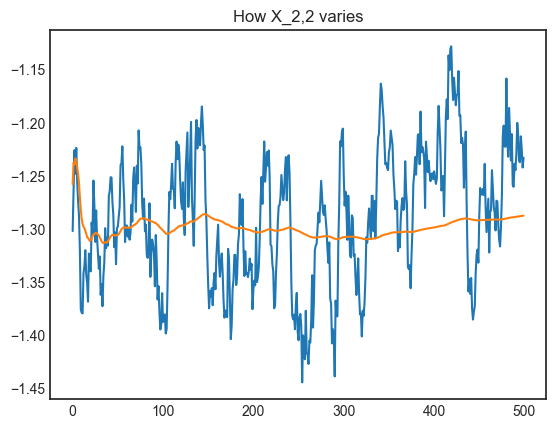

In [401]:
n = len(X_mean_array)
X_mean_array = np.array(X_mean_array)
#print(X[2, 2])
plt.plot(range(n), X_mean_array[:, 2, 2])
plt.plot(range(n), X_average[:, 2, 2])
#plt.axhline(y=X[1,1], color='r', linestyle='-')
plt.title('How X_2,2 varies')

(500, 100, 50)


Text(0.5, 1.0, 'How Average of reconsutrcted Y_2,2 varies')

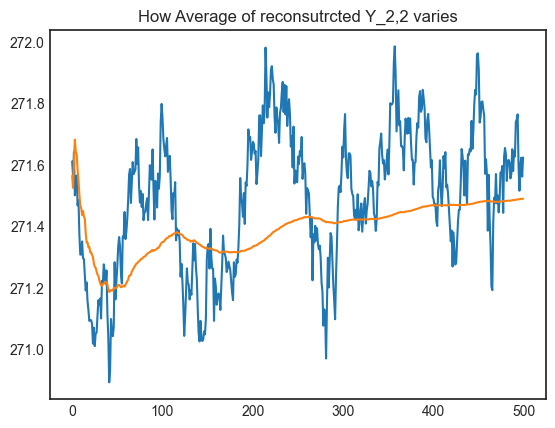

In [402]:
Y_array = np.array([C @ X for C, X in zip(C_mean_array, X_mean_array)])
print(Y_array.shape)
plt.plot(range(n), Y_array[:, 2, 2], label='Y constructed from the means of C and X at each iteration')
plt.plot(range(n), Y_pred_running[:, 2, 2], label='Y constructed from the running average of samples output of C and X')   
plt.title('How Average of reconsutrcted Y_2,2 varies')


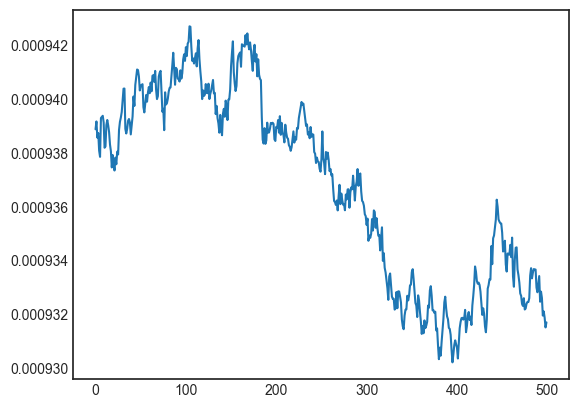

In [403]:
#plot the V

V_samples = np.array(V_samples)
plt.plot(range(T-burnin), V_samples[:, 2, 2])

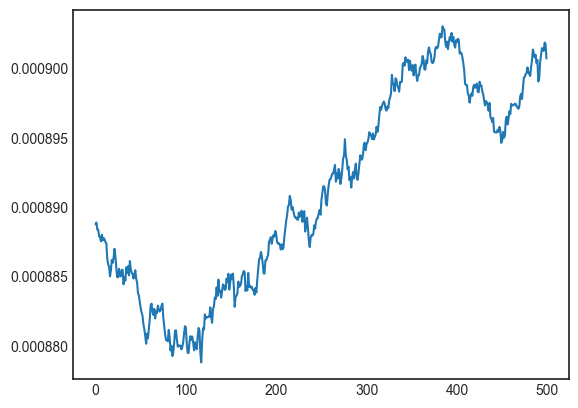

In [404]:
#plot the W

W_samples = np.array(W_samples)
plt.plot(range(T-burnin), W_samples[:, 2, 2])

### Marginal Likelihood from BGMF for different values of r

In BGMF, we implement Gibbs Sampling for complete conditionals which we derived:

$$
f(C|Y, X) = \mathcal{N}(c;c_p, V \otimes I_m) = \mathcal{MN}(C;C_p, I_m, V), 
$$
$$
f(X|Y, C) = \mathcal{N}(c;x_p, I_n \otimes W) = \mathcal{MN}(X;X_p, W, I_n), 
$$

Using https://www.tandfonline.com/doi/pdf/10.1080/01621459.1995.10476635, the estimate of the marginal likelihood is:

$$
\log p(Y) = \log P(Y|C^*,X^*) + \log p(X^*) + \log p(C^*) - \log p(C^*|X^*,Y) - \log p(X^*|Y)
$$


where $C^*$ and $X^*$ are our selected points taken to be the average points of sampler output from our outputs of BGMF $\{C^{(t)}, X^{(t)}\}_{t=1}^T$.

The last term can be estimated by:

$$
p(\widehat{X^*|Y}) = \frac{1}{T}\sum_{i=1}^Tp(X^*|C^{(i)}, Y)
$$



In [343]:
def evaluate_log_density(X, M, U, V):
    #evaluates log pdf for X that follows MN(M, U, V)
    n, p = X.shape
    log_density = -0.5 * np.trace(np.linalg.solve(V, (X-M).T) @ np.linalg.solve(U, (X - M)))
    log_density -= 0.5 * (n * p * np.log(2*np.pi) + n * np.log(np.linalg.det(V)) + p * np.log(np.linalg.det(U)))
    return log_density

In [344]:
def log_marginal_likelihood(C_samples, X_samples, V_samples, W_samples, Y, sigma_2, C_0, X_0, V_0, W_0):
    
    m, n = Y.shape
    C_star = calculate_running_average(C_samples)[-1]
    X_star = calculate_running_average(X_samples)[-1]
    T = len(X_samples)
    term1 = evaluate_log_density(Y, C_star@X_star, sigma_2*np.eye(m), sigma_2*np.eye(n))
    term2 = evaluate_log_density(X_star, X_0, W_0, np.eye(n))
    term3 = evaluate_log_density(C_star, C_0, np.eye(m), V_0)
    
    C_p = C_0 + (Y - C_0 @ X_star) @ np.linalg.inv((sigma_2*np.eye(n) + X_star.T @ V_0 @ X_star)).T @ X_star.T @ V_0.T
    V_p = V_0 - V_0 @ X_star @ np.linalg.inv(sigma_2*np.eye(n) + X_star.T @ V_0 @ X_star).T @ X_star.T @ V_0.T
    term4 = evaluate_log_density(C_star, C_p, np.eye(m), V_p)
    
    X_p_array = [X_0 + W_0 @ C_i.T @ np.linalg.inv(sigma_2*np.eye(m) + C_i @ W_0 @ C_i.T) @ (Y - C_i @ X_0) for C_i in C_samples]
    #W_p = W_0 - W_0 @ C_star.T @ np.linalg.inv(sigma_2*np.eye(m) + C_star @ W_0 @ C_star.T) @ C_star @ W_0
    W_p_array = [W_0 - W_0 @ C_i.T @ np.linalg.inv(sigma_2*np.eye(m) + C_i @ W_0 @ C_i.T) @ C_i @ W_0 for C_i in C_samples]
    
    #term5_log_array = [evaluate_log_density(X_star, X_p, W_p, np.eye(n)) for X_p in X_p_array]
    term5_log_array = [evaluate_log_density(X_star, X_p, W_p, np.eye(n)) for X_p, W_p in zip(X_p_array, W_p_array)]
    
    term5 = logsumexp(term5_log_array) - np.log(T)
    print(term1, term2, term3, term4, term5)
    return term1 + term2 + term3 - term4 - term5
    

In [345]:
res = log_marginal_likelihood(C_samples, X_samples, V_samples, W_samples, Y, sigma_2, C_0, X_0, V_0, W_0)


-6826.897592684489 -127587.0514544827 -5930514.293611135 -278463.9291803765 -6467.526425535463


### Plot for different values of r

-227.06337764037752 -1909.462492915806 -1245.305701482107 -976.9818702630159 -1718.325355280979
-131.2162712436865 -3015.4999059871325 -1272.2426694492597 -1053.9667575697176 -2789.0300754287055
-116.39342753807115 -2794.2452973585414 -2555.8066222926127 -2187.5227618634967 -2569.5533305705135
-108.81198560579904 -2456.213650333659 -1775.9020371211157 -1518.0097497069937 -2290.6433921124453
-107.3248588263063 -4519.363505345242 -2712.661154628603 -2372.4962863902842 -4247.060465662236
-109.56001944436466 -3982.879956552416 -2558.6325424919455 -2210.9766668693874 -3790.200317651801
-103.25739082807726 -6349.686863700576 -1880.7609389299246 -1476.8112860346484 -6172.175313422028
-100.97625900990049 -5235.95755903479 -2172.3975102160475 -1951.0878958448914 -4875.696024095923
-101.60966585773427 -5304.088870718837 -3194.1238506765603 -2668.0736178223447 -5017.207327703584


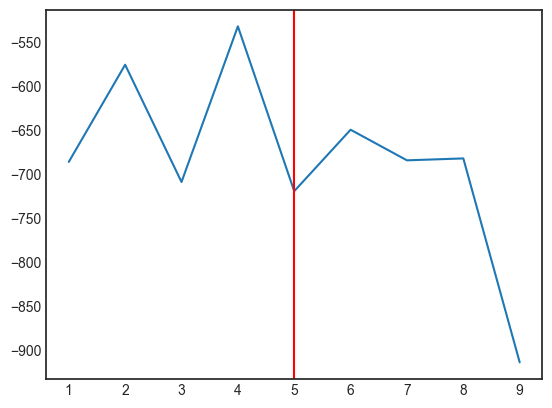

In [366]:
np.random.seed(0)
m = 7
n = 13
true_r = 5
burnin = 1000
T = 5000
k = 0.01
sigma_2 = 1

r_vals = [i for i in range(1, 10)]
log_likelihoods = []

#Generate data
C = np.random.normal(0, 1, size=(m, true_r))
X = np.random.normal(0, 1, size=(true_r, n))
Y = C @ X

for r in r_vals:
    C_pred, X_pred, C_samples, X_samples, V_samples, W_samples, C_0, X_0, V_0, W_0, _, _ \
                    = BGMF(Y, k, r, T, sigma_2, burnin = burnin, return_samples = True)
    
    log_likelihoods.append(log_marginal_likelihood(C_samples, X_samples, V_samples, W_samples, Y, sigma_2, C_0, X_0, V_0, W_0))
    
plt.plot(r_vals, log_likelihoods)
plt.axvline(true_r, color='r')